# KAN: Kolmogorov-Arnold Networks Demo

This notebook demonstrates the KAN (Kolmogorov-Arnold Networks) implementation in pycse.

## What are KANs?

KANs are neural networks based on the Kolmogorov-Arnold representation theorem, which states that any multivariate continuous function can be represented as a composition of continuous functions of a single variable and addition.

**Key differences from MLPs:**
- MLPs have fixed activation functions on **nodes** (neurons)
- KANs have **learnable activation functions on edges** (connections)
- KAN activations are parameterized using B-splines

**Advantages:**
- Can be more interpretable (each edge learns a specific transformation)
- Often more parameter-efficient for smooth functions
- Better at learning symbolic/mathematical relationships

Reference: Liu, Z., et al. (2024). KAN: Kolmogorov-Arnold Networks. arXiv:2404.19756.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Import KAN from pycse
from pycse.sklearn.kan import KAN

## 1. Basic Usage: Fitting a Simple Function

Let's start with a simple example: fitting a sine wave.

In [2]:
# Generate sinusoidal data with noise
np.random.seed(42)
X = np.linspace(0, 2 * np.pi, 150)[:, None]
y_true = np.sin(X.ravel())
y = y_true + 0.1 * np.random.randn(150)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train KAN
# layers=(1, 8, 1) means: 1 input, 8 hidden neurons, 1 output
model = KAN(layers=(1, 8, 1), grid_size=8)
model.fit(X_train, y_train, maxiter=500)

# Report training results
model.report()

KAN Optimization Report:
  Architecture: (1, 8, 1)
  Grid size: 8
  Spline order: 3
  Optimizer: bfgs
  Iterations: 201
  Final loss: 0.016584
  Converged: True


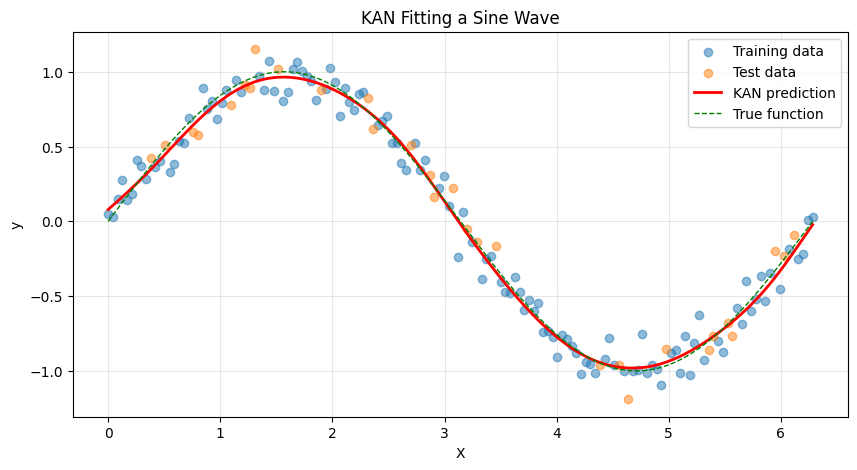

R² score on test set: 0.9801


In [3]:
# Make predictions
y_pred = model.predict(X)

# Visualize results
plt.figure(figsize=(10, 5))
plt.scatter(X_train, y_train, alpha=0.5, label='Training data')
plt.scatter(X_test, y_test, alpha=0.5, label='Test data')
plt.plot(X, y_pred, 'r-', linewidth=2, label='KAN prediction')
plt.plot(X, y_true, 'g--', linewidth=1, label='True function')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('KAN Fitting a Sine Wave')
plt.grid(True, alpha=0.3)
plt.show()

# Print R² score
print(f"R² score on test set: {model.score(X_test, y_test):.4f}")

## 2. Uncertainty Quantification with KAN

By using an ensemble output (multiple outputs in the final layer), KAN can provide uncertainty estimates similar to DPOSE.

In [4]:
# Generate heteroscedastic data (noise increases with X)
np.random.seed(42)
X = np.linspace(0, 1, 200)[:, None]
noise_level = 0.02 + 0.15 * X.ravel()  # Increasing noise
y = X.ravel() ** (1/3) + noise_level * np.random.randn(200)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create KAN with ensemble output for UQ
# layers=(1, 10, 32) means: 1 input, 10 hidden, 32 ensemble members
model_uq = KAN(
    layers=(1, 10, 32),
    grid_size=5,
    loss_type='crps',  # CRPS loss for uncertainty training
)

# Fit with validation data for calibration
model_uq.fit(X_train, y_train, val_X=X_val, val_y=y_val, maxiter=500)
model_uq.report()


Calibration factor α = 1.0451
  ✓ Model is well-calibrated


KAN Optimization Report:
  Architecture: (1, 10, 32)
  Grid size: 5
  Spline order: 3
  Optimizer: bfgs
  Iterations: 500
  Final loss: 0.208315
  Converged: False
  Calibration: α = 1.0451


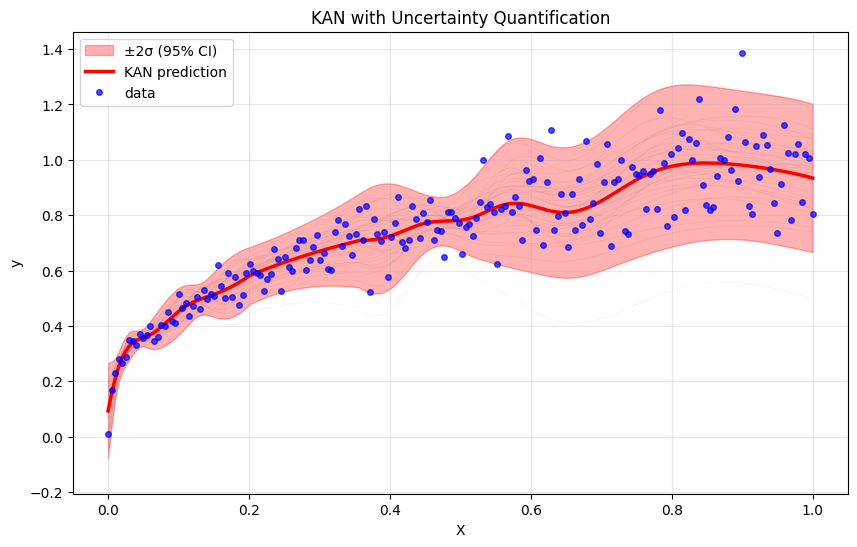

In [5]:
# Use the built-in plot method
plt.figure(figsize=(10, 6))
model_uq.plot(X, y, distribution=True)
plt.title('KAN with Uncertainty Quantification')
plt.show()

In [6]:
# Print uncertainty metrics
model_uq.print_metrics(X_val, y_val)


KAN UNCERTAINTY QUANTIFICATION METRICS
Prediction Accuracy:
  RMSE: 0.101721
  MAE:  0.072387

Uncertainty Quality:
  NLL: -1.039732
  Miscalibration Area: 0.025147

Calibration Diagnostics:
  Z-score mean: 0.0957 (ideal: 0)
  Z-score std:  1.0064 (ideal: 1)



## 3. Comparing KAN with Different Grid Sizes

The `grid_size` parameter controls the expressiveness of the B-spline activation functions.

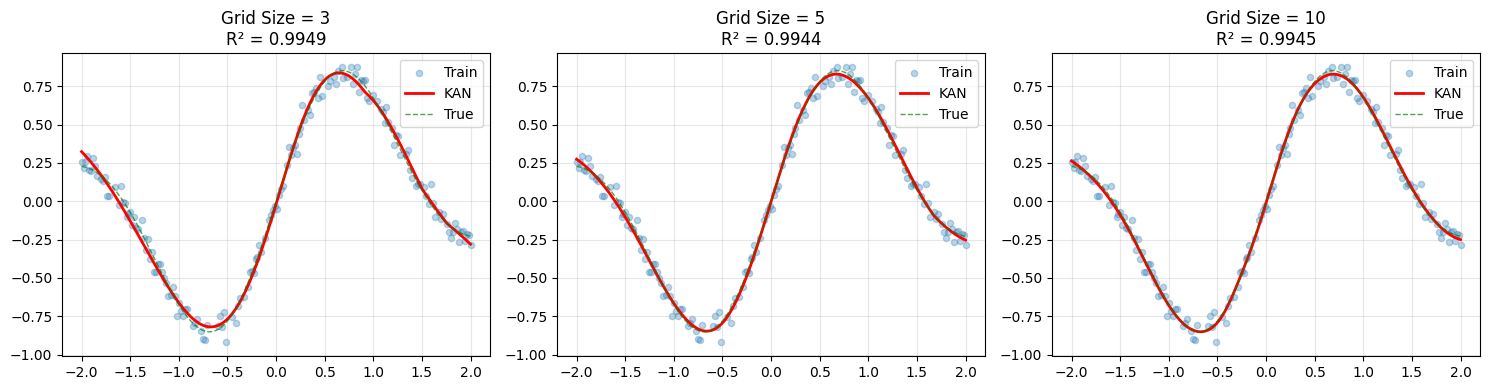

In [7]:
# Generate a more complex function
np.random.seed(42)
X = np.linspace(-2, 2, 200)[:, None]
y_true = np.sin(2 * X.ravel()) * np.exp(-0.3 * X.ravel()**2)
y = y_true + 0.05 * np.random.randn(200)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Test different grid sizes
grid_sizes = [3, 5, 10]
models = []

fig, axes = plt.subplots(1, len(grid_sizes), figsize=(15, 4))

for ax, grid_size in zip(axes, grid_sizes):
    model = KAN(layers=(1, 6, 1), grid_size=grid_size)
    model.fit(X_train, y_train, maxiter=500)
    models.append(model)
    
    y_pred = model.predict(X)
    score = model.score(X_test, y_test)
    
    ax.scatter(X_train, y_train, alpha=0.3, s=20, label='Train')
    ax.plot(X, y_pred, 'r-', linewidth=2, label='KAN')
    ax.plot(X, y_true, 'g--', linewidth=1, alpha=0.7, label='True')
    ax.set_title(f'Grid Size = {grid_size}\nR² = {score:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Multi-dimensional Input

KANs can also handle multiple input features.

In [8]:
# Generate 2D function: z = sin(x) * cos(y)
np.random.seed(42)
n_samples = 500
X = np.random.uniform(-np.pi, np.pi, (n_samples, 2))
y_true = np.sin(X[:, 0]) * np.cos(X[:, 1])
y = y_true + 0.1 * np.random.randn(n_samples)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train KAN
model_2d = KAN(layers=(2, 8, 1), grid_size=5)
model_2d.fit(X_train, y_train, maxiter=500)

model_2d.report()
print(f"\nR² on test set: {model_2d.score(X_test, y_test):.4f}")

KAN Optimization Report:
  Architecture: (2, 8, 1)
  Grid size: 5
  Spline order: 3
  Optimizer: bfgs
  Iterations: 500
  Final loss: 0.031099
  Converged: False



R² on test set: 0.9529


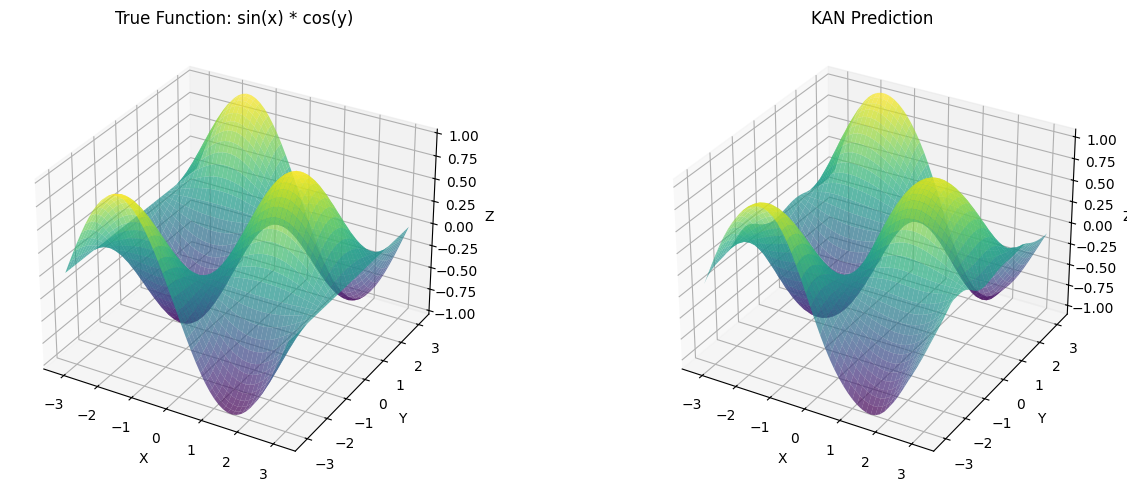

In [9]:
# Visualize the 2D function
from mpl_toolkits.mplot3d import Axes3D

# Create a grid for visualization
x_grid = np.linspace(-np.pi, np.pi, 50)
y_grid = np.linspace(-np.pi, np.pi, 50)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
XY_flat = np.column_stack([X_grid.ravel(), Y_grid.ravel()])

# Predict on grid
Z_pred = model_2d.predict(XY_flat).reshape(X_grid.shape)
Z_true = (np.sin(X_grid) * np.cos(Y_grid))

fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X_grid, Y_grid, Z_true, cmap='viridis', alpha=0.7)
ax1.set_title('True Function: sin(x) * cos(y)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_grid, Y_grid, Z_pred, cmap='viridis', alpha=0.7)
ax2.set_title('KAN Prediction')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

## 5. Comparison: KAN vs Standard MLP (DPOSE)

Let's compare KAN with DPOSE on the same task.

In [10]:
from pycse.sklearn.dpose import DPOSE

# Generate data with a moderately complex function
np.random.seed(42)
X = np.linspace(0, 4 * np.pi, 200)[:, None]
y_true = np.sin(X.ravel()) + 0.3 * np.sin(3 * X.ravel())
y = y_true + 0.1 * np.random.randn(200)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train KAN
kan_model = KAN(layers=(1, 10, 1), grid_size=8)
kan_model.fit(X_train, y_train, maxiter=500)

# Train DPOSE (standard MLP)
dpose_model = DPOSE(layers=(1, 20, 1), loss_type='mse')
dpose_model.fit(X_train, y_train, maxiter=500)

# Compare
kan_score = kan_model.score(X_test, y_test)
dpose_score = dpose_model.score(X_test, y_test)

print(f"KAN R² score: {kan_score:.4f}")
print(f"DPOSE R² score: {dpose_score:.4f}")

KAN R² score: 0.9846
DPOSE R² score: -0.0423


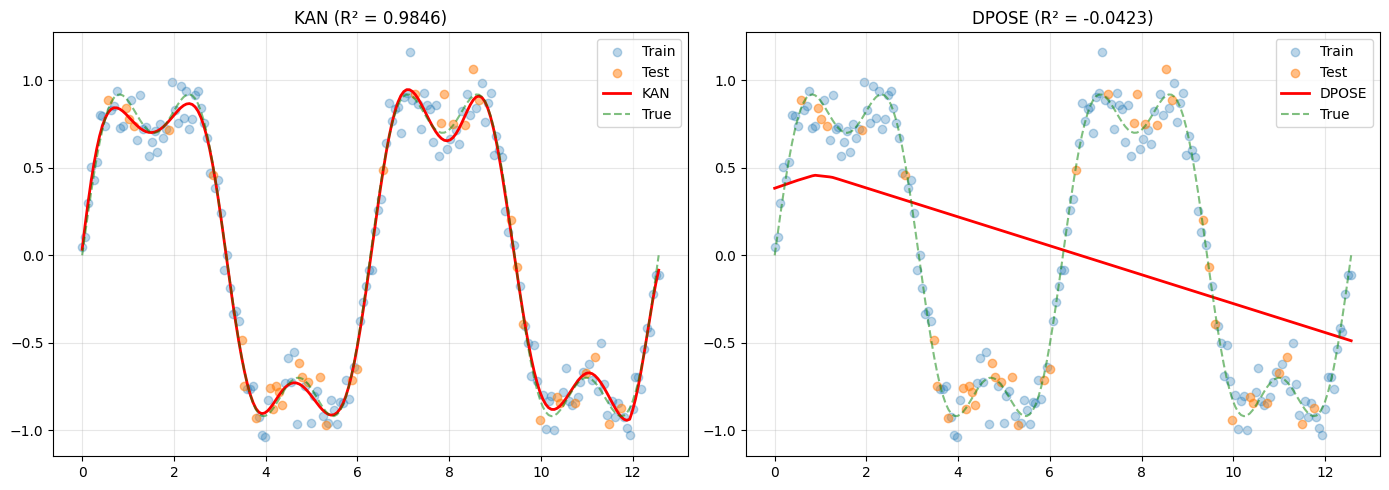

In [11]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KAN predictions
y_kan = kan_model.predict(X)
axes[0].scatter(X_train, y_train, alpha=0.3, label='Train')
axes[0].scatter(X_test, y_test, alpha=0.5, label='Test')
axes[0].plot(X, y_kan, 'r-', linewidth=2, label='KAN')
axes[0].plot(X, y_true, 'g--', alpha=0.5, label='True')
axes[0].set_title(f'KAN (R² = {kan_score:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# DPOSE predictions
y_dpose = dpose_model.predict(X)
axes[1].scatter(X_train, y_train, alpha=0.3, label='Train')
axes[1].scatter(X_test, y_test, alpha=0.5, label='Test')
axes[1].plot(X, y_dpose, 'r-', linewidth=2, label='DPOSE')
axes[1].plot(X, y_true, 'g--', alpha=0.5, label='True')
axes[1].set_title(f'DPOSE (R² = {dpose_score:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Uncertainty Propagation

Like DPOSE, KAN with ensemble output supports uncertainty propagation for derived quantities.

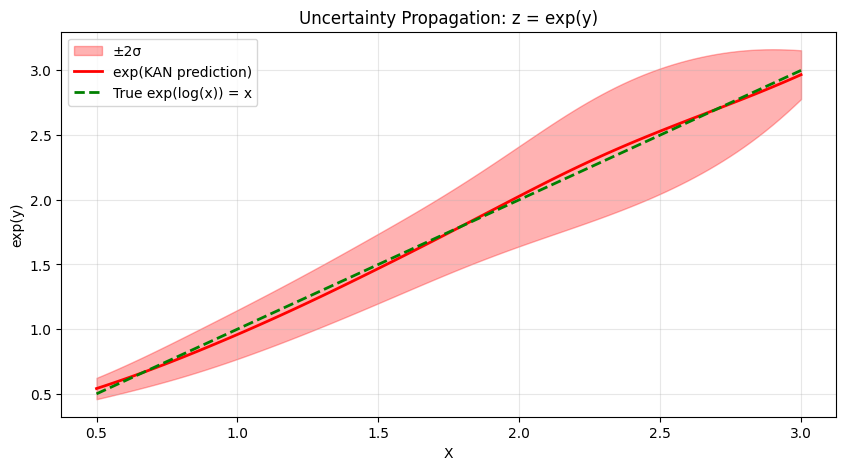

In [12]:
# Generate data
np.random.seed(42)
X = np.linspace(0.5, 3, 100)[:, None]
y = np.log(X.ravel()) + 0.1 * np.random.randn(100)

# Train KAN with ensemble for UQ
model = KAN(layers=(1, 8, 32), grid_size=5, loss_type='crps')
model.fit(X, y, maxiter=500)

# Get ensemble predictions
ensemble_preds = model.predict_ensemble(X)  # shape: (n_samples, n_ensemble)

# Propagate through a nonlinear transformation: z = exp(y)
z_ensemble = np.exp(ensemble_preds)
z_mean = z_ensemble.mean(axis=1)
z_std = z_ensemble.std(axis=1)

# Compare with true values
z_true = np.exp(np.log(X.ravel()))  # = X

plt.figure(figsize=(10, 5))
plt.fill_between(X.ravel(), z_mean - 2*z_std, z_mean + 2*z_std, alpha=0.3, color='red', label='±2σ')
plt.plot(X, z_mean, 'r-', linewidth=2, label='exp(KAN prediction)')
plt.plot(X, z_true, 'g--', linewidth=2, label='True exp(log(x)) = x')
plt.xlabel('X')
plt.ylabel('exp(y)')
plt.legend()
plt.title('Uncertainty Propagation: z = exp(y)')
plt.grid(True, alpha=0.3)
plt.show()

## Summary

The KAN (Kolmogorov-Arnold Network) implementation in pycse provides:

1. **Learnable activations**: B-spline basis functions for flexible activation learning
2. **sklearn compatibility**: Follows BaseEstimator/RegressorMixin interface
3. **Uncertainty quantification**: Via ensemble output and calibration
4. **Flexible architecture**: Configurable grid size, spline order, and layer sizes
5. **Multiple optimizers**: BFGS, Adam, SGD support

### When to use KAN:
- When you expect the underlying function to be smooth
- When interpretability matters (each edge learns a specific transformation)
- For scientific/mathematical modeling where functions are often compositions of simpler functions

### Parameters to tune:
- `grid_size`: More intervals = more expressive but more parameters (default: 5)
- `layers`: Network architecture (include ensemble size as last element for UQ)
- `spline_order`: Higher = smoother, typically 3 (cubic) is a good choice